In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
base_dirs = {
    "Without": Path("data/Without EDM"),
    "With": Path("data/With EDM")
}

dfs = []

for edm_state, dir_path in base_dirs.items():
    for file in sorted(dir_path.glob("G2_*.pkl")):
        run_id = int(file.stem.split("_")[1])
        with open(file, "rb") as f:
            X, Y, Z = pickle.load(f)
        
        df = pd.DataFrame({
            "lambda_frac": X.ravel(),
            "theta_mrad": (Y * 1000).ravel(),
            "prob_density": Z.ravel(),
            "run_id": run_id,
            "edm_state": edm_state
        })
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [4]:
output_base = Path("outputs")
save = False

if save:
    for edm_state in tqdm(["With", "Without"], desc="EDM States"):
        # Match the folder names on disk
        folder_name = "With EDM" if edm_state == "With" else "Without EDM"
        output_dir = output_base / folder_name
        output_dir.mkdir(parents=True, exist_ok=True)

        for run_id in range(29):
            subset = df_all.query("edm_state == @edm_state and run_id == @run_id")
            if subset.empty:
                print(f"Skipping {edm_state} run {run_id:02} — no data found.")
                continue

            # Get unique sorted axes
            lambdas = np.sort(subset["lambda_frac"].unique())
            thetas = np.sort(subset["theta_mrad"].unique())

            # Reshape back into 2D grid
            Z_grid = subset.pivot_table(
                index="theta_mrad",
                columns="lambda_frac",
                values="prob_density"
            ).values

            # File name format
            if edm_state == "With":
                fname = f"G2_{run_id:02}_withEDM_heatmap.png"
            else:
                fname = f"G2_{run_id:02}_heatmap.png"

            save_path = output_dir / fname

            # Plot and save with no inline output
            plt.figure(figsize=(6,6))
            plt.imshow(
                Z_grid,
                extent=[lambdas.min(), lambdas.max(), thetas.min(), thetas.max()],
                aspect='auto',
                origin='lower',
                cmap='viridis'
            )
            plt.xlabel(r"Fractional energy ($\lambda$)")
            plt.ylabel(r"Longitudinal angle ($\theta_L$) [mrad]")
            plt.title(f"{folder_name} — Run {run_id:02}")
            plt.colorbar(label="Probability density")
            plt.tight_layout()
            plt.savefig(save_path, dpi=200)
            plt.close()

            print(f"Saved: {save_path.resolve()}")
else:
    print("Files already saved.")


Files already saved.


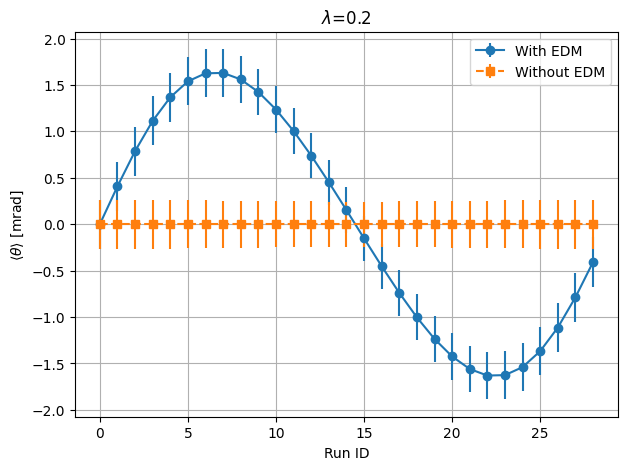

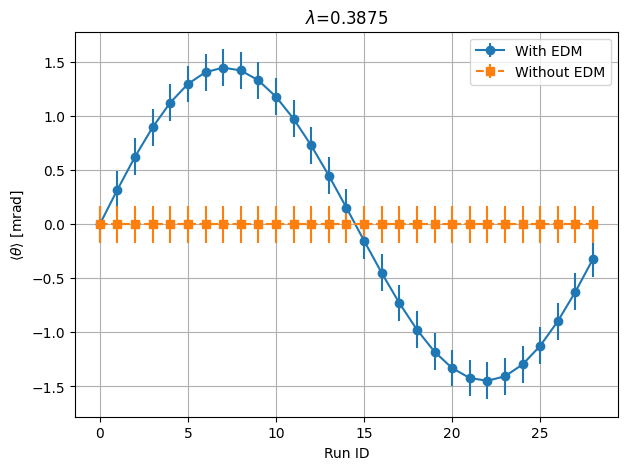

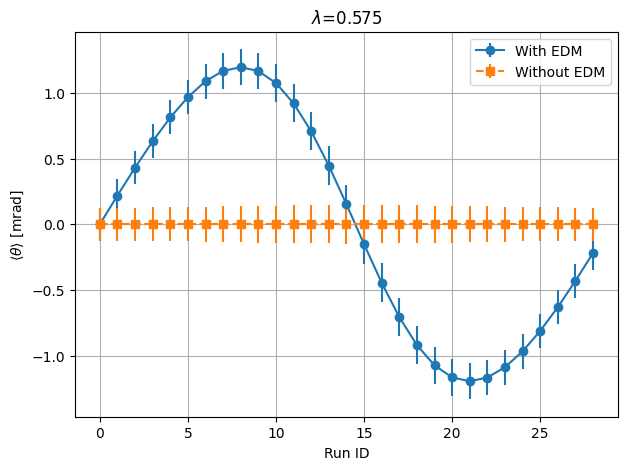

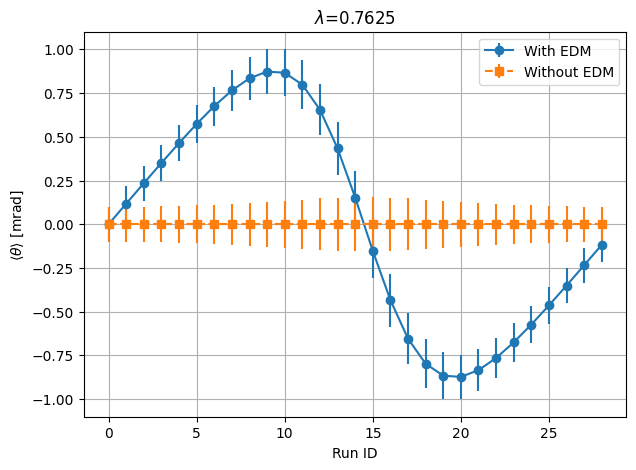

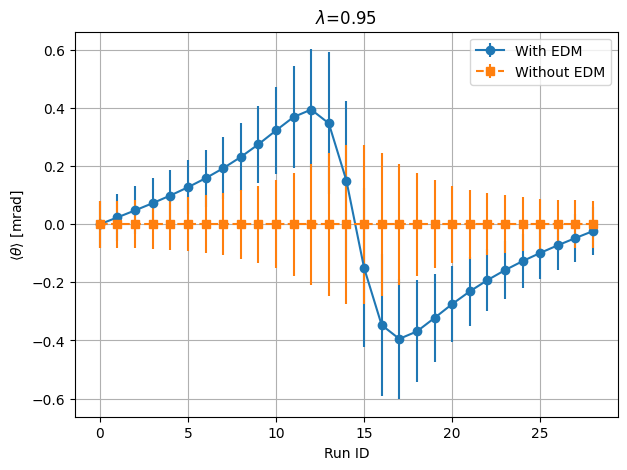

In [12]:
dftemp = df_all.query("edm_state == 'With' and run_id == 0 and lambda_frac==0.2")
dftemp.reset_index(drop=True, inplace=True)
dtheta = np.fabs(dftemp["theta_mrad"].loc[0] - dftemp["theta_mrad"].loc[1])

dftemp_theta = df_all.query("edm_state == 'With' and run_id == 0 and theta_mrad==200.0")
dftemp_theta.reset_index(drop=True, inplace=True)
dlambda = np.fabs(dftemp_theta["lambda_frac"].loc[0] - dftemp_theta["lambda_frac"].loc[1])

#for i in range(29):
#    dftemp = df_all.query(f"edm_state == 'With' and run_id == {i}")
#    print(i, dftemp["prob_density"].sum() * dtheta * dlambda * 1e-3)


generate_n = False
steps = 5

lambda_values = np.linspace(0.2,0.95,steps)


if generate_n:
    n_vals = [1, 10, 100, 1000, 2500, 5000, 7500, 10000]
else:
    n_vals=[10000]

metrics = {}

def CalculateMetrics(g, n):
    probs = n * g["prob_density"] * 1e-3
    theta = g["theta_mrad"]
    w_mean = np.sum(theta * probs) / np.sum(probs)
    w_var = np.sum(probs * theta**2) / np.sum(probs) - w_mean**2
    w_sem = np.sqrt(w_var) / np.sqrt(np.sum(probs))
    return pd.Series({"mean": w_mean, "wsig":np.sqrt(w_var), "sem": w_sem})

for n_curr in n_vals:
    all_metrics = []
    for lambda_curr in lambda_values:
        closest_idx = (df_all["lambda_frac"] - lambda_curr).abs().idxmin()
        closest_lambda = df_all.loc[closest_idx, "lambda_frac"]
        subset = df_all[df_all["lambda_frac"] == closest_lambda]
        results = (
        subset
        .groupby(["edm_state", "run_id"])
        .apply( lambda g: CalculateMetrics(g,n_curr),include_groups=False)
        )

        angles = results.unstack("edm_state")

        means = results["mean"].unstack("edm_state")
        stddev = results["wsig"].unstack("edm_state")
        errors = results["sem"].unstack("edm_state")
        FOM = np.sum(means["With"]**2 / (2 * errors["With"]**2))
        all_metrics.append({
            "lambda_frac": lambda_curr,
            "FOM": FOM
        })

        plt.figure(figsize=(7,5))
        plt.title(fr"$\lambda$={lambda_curr}")
        plt.errorbar(means.index, means["With"], yerr=errors["With"], fmt="o-", label="With EDM")
        plt.errorbar(means.index, means["Without"], yerr=errors["Without"], fmt="s--", label="Without EDM")
        plt.xlabel("Run ID")
        plt.ylabel(r"$\langle\theta\rangle$ [mrad]")
        plt.legend()
        plt.grid(True)
        plt.show()
    metrics[n_curr] = pd.DataFrame(all_metrics)


   lambda_frac         FOM
0       0.2000  296.645056
1       0.3875  523.658137
2       0.5750  554.628882
3       0.7625  343.065621
4       0.9500   33.134041


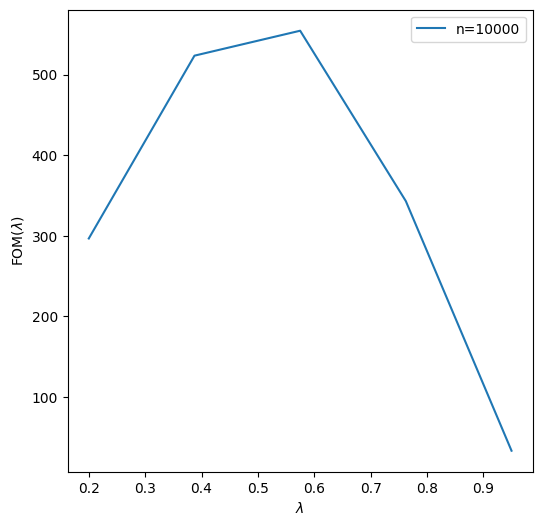

In [13]:
fig = plt.figure(figsize=(6,6))
for n_curr in n_vals:
    print(metrics[n_curr])
    plt.plot(metrics[n_curr]["lambda_frac"],metrics[n_curr]["FOM"],label=f"n={n_curr}")

plt.xlabel(r"$\lambda$")
plt.ylabel(r"FOM($\lambda$)")
plt.legend()
plt.show()

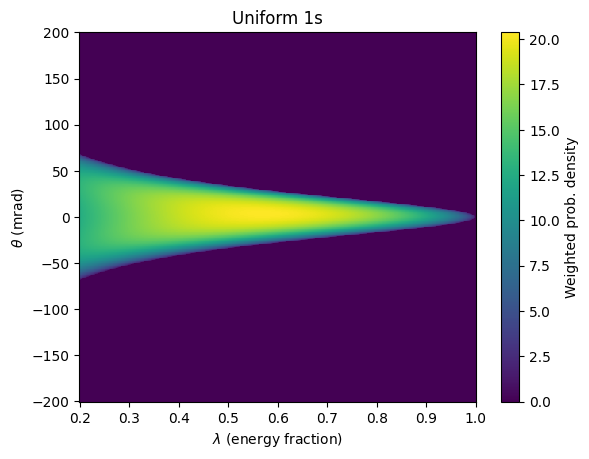

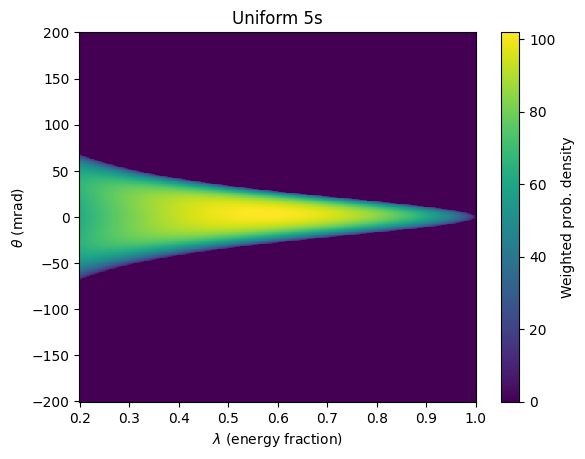

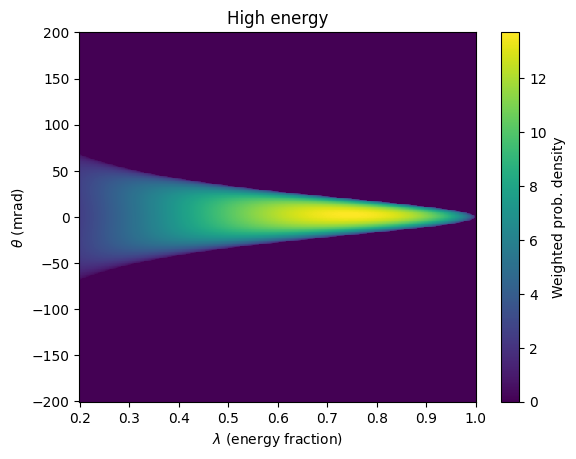

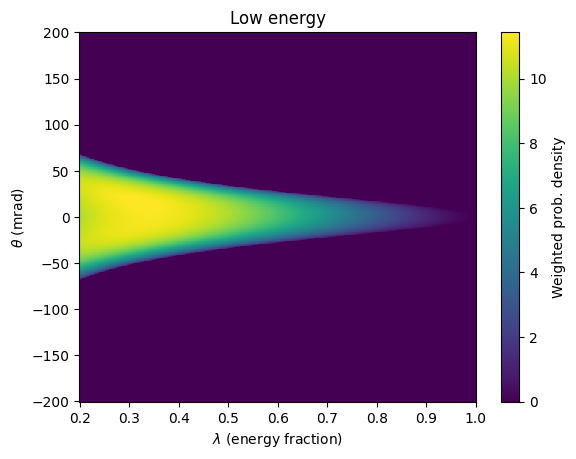

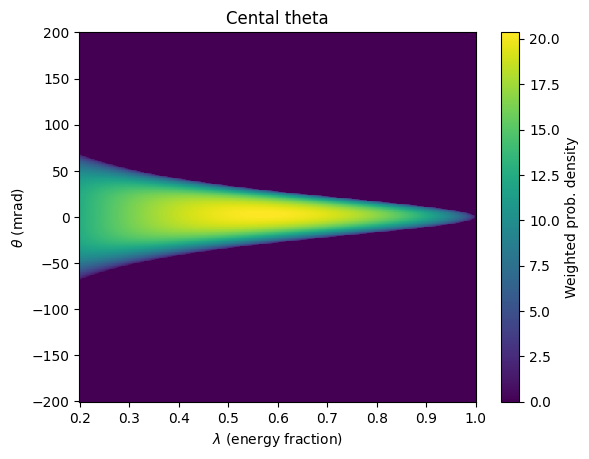

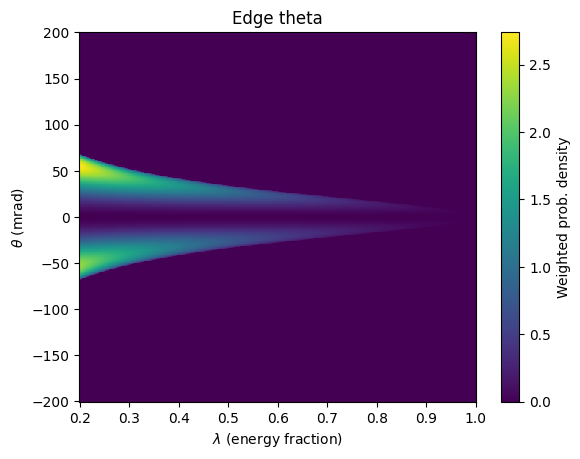

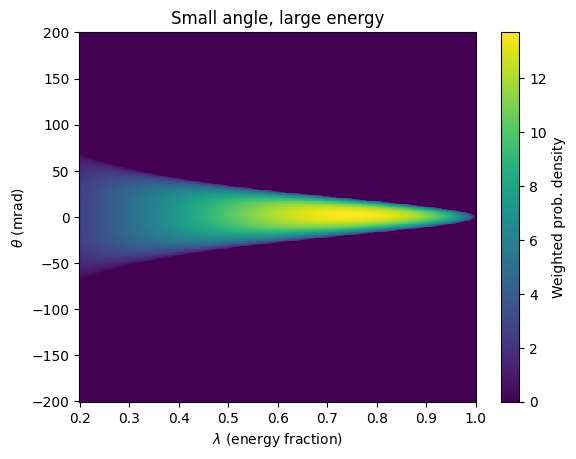

In [ ]:
df_weighted = df_all.query("edm_state=='With' and run_id == 7")

df_grid = df_weighted.pivot_table(
    index="theta_mrad",
    columns="lambda_frac",
    values="prob_density"
)

theta_vals = df_grid.index.values
lambda_vals = df_grid.columns.values

TH, LAM = np.meshgrid(theta_vals, lambda_vals, indexing='ij')

weights_dict = {
    "Uniform 1s" : np.ones(TH.shape),
    "Uniform 5s" : 5*np.ones(TH.shape),
    "High energy" : LAM,
    "Low energy" : 1 - LAM/LAM.max(),
    "Cental theta" : np.exp(-((TH / 100)**2)),
    "Edge theta" : 1 - np.exp(-((TH / 100)**2)),
    "Small angle, large energy": np.exp(-((TH / 100)**2)) * LAM,
}

for name, w in weights_dict.items():
    weighted = df_grid.values * w
    plt.figure()
    plt.pcolormesh(lambda_vals, theta_vals, weighted, shading='auto')
    plt.title(name)
    plt.xlabel(r"$\lambda$ (energy fraction)")
    plt.ylabel(r"$\theta$ (mrad)")
    plt.colorbar(label="Weighted prob. density")
    plt.savefig(f"outputs/Weighting/{name}.png")
    plt.show()
